In [1]:
from support_functions import *
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
from qiskit_experiments.library import QuantumVolume

In [2]:
def all_keys(q):
    keys = []
    vector = [0 for _ in range(q)]
    while(vector[-1]<2):
        keystr = ''
        for b in vector:
            keystr += str(b)
        keys.append(keystr)
        
        vector[0] += 1
        for i in range(0,q-1):
            if( vector[i] >= 2):
                vector[i] = 0
                vector[i+1] += 1
            else:
                break
    return keys

#allkeys = all_keys(6)
#print(allkeys)

In [3]:
def Generate_QuantumVolumeCircuits(nr_qubits, nr_of_circuits):
    qv = QuantumVolume([i for i in range(nr_qubits)], trials=nr_of_circuits)
    circs = qv.circuits()
    return circs

In [4]:
b = 24
N = 1000
n_tests = 20#

In [5]:
def HU_found(circ, noise_thermal, nr_qubits):
    """
    
    """
    tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(nr_qubits), optimization_level=3)
    
    counts1 = clean_exc(tdc)
    srt_lst1 = []
    for key in all_keys(nr_qubits):
        k = key
        l = 0
        if key in counts1.keys():
            l = counts1[key]
        insert = 0
        for i in range(len(srt_lst1)):
            if( l > srt_lst1[i][1] ):
                srt_lst1.insert(i,[k,l].copy())
                insert=1
                break
        if(insert==0):
            srt_lst1.append([k,l].copy())
    HU1 = [ k for [k,_] in srt_lst1[0:int(2**(nr_qubits-1))] ]
    """
    ctr1 = 0
    ctr2 = 0
    for i in range(2**nr_qubits):
        ctr2 += srt_lst1[i][1]
        if(i<2**(nr_qubits-1)):
            ctr1 += srt_lst1[i][1]
        print(i, ctr2, round(ctr1/ctr2,2), srt_lst1[i][1], srt_lst1[i][0] )
    """   
    f_ho = sum(  l for [_,l] in srt_lst1[0:int(2**(nr_qubits-1))]  ) / sum(  l for [_,l] in srt_lst1  )
    #print(f_ho)
    
    nr_heavy_outputs = 0
    nr_measurements = 0;
    
    counts2 = noisy_exc(tdc, noise_thermal)
    srt_lst2 = []
    for key in counts2.keys():
        k = key
        l = counts2[key]
        nr_measurements += l
        if k in HU1:
            nr_heavy_outputs += l
        
            
    return nr_heavy_outputs/nr_measurements, nr_measurements, f_ho

In [6]:
#"""
IBMQ.load_account()

# listing the providers you have access to 
IBMQ.providers()
# Use your provider to access "premium" devices
provider = IBMQ.get_provider(hub='ibm-q-qal', group='tno', project='miscellaneous')
# listing backends your provider have access to 
provider.backends()

# Selecting ibm_perth
backend = provider.get_backend('ibm_perth')
print(backend.name())
noise_perth = NoiseModel.from_backend(backend)
#"""

/tmp/ipykernel_10099/203496565.py:2: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/tmp/ipykernel_10099/203496565.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


ibm_perth


# QV-experiments

In [7]:
def loss_results(results, b_d, c_d, b_s, c_s):
    loss_s = 0.0
    loss_d = 0.0
    for [q, ctr, agd, ags, a] in results:
        power_d = (agd/100)*(7/q)
        power_s = (ags/100)#*(7/q)
        a_d = b_d * (c_d**power_d)
        a_s = b_s * (c_s**power_s)
        loss_d += ctr * (a-a_s)**2
        loss_s += ctr * (a-a_s)**2
    return loss_d, loss_s

def find_bc(results):
    b_s = 1.0
    c_s = 0.5
    b_d = 1.0
    c_d = 0.5
    loss_d, loss_s = loss_results(results, b_d, c_d, b_s, c_s)
    
    for i in range(100):
        for j in range(100):
            bd2 = 1.000 - 0.002*i
            cd2 = 0.01*j
            loss2d, _ = loss_results(results, bd2, cd2, b_s, c_s)
            if(loss2d<loss_d):
                b_d = bd2
                c_d = cd2
                loss_d = loss2d
    
    for i in range(100):
        for j in range(100):
            bs2 = 1.000 - 0.002*i
            cs2 = 0.01*j
            _, loss2s = loss_results(results, b_d, c_d, bs2, cs2)
            if(loss2s<loss_s):
                b_s = bs2
                c_s = cs2
                loss_s = loss2s

    return b_d, c_d, loss_d, b_s, c_s, loss_s

In [8]:
%%time
results = []
for q in range(4,11):
    nh = 0
    nc = n_tests 
    ns = -1
    fho_avg = 0.0
    x_avg = 0
    x_var = 0
    ctr = n_tests
    avg_gate_depth = 0
    avg_gate_size = 0
    circs = Generate_QuantumVolumeCircuits(q, n_tests)
    for i in range(n_tests):
        circ = circs[i]
        tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
        avg_gate_depth += tdc.depth()
        avg_gate_size += tdc.size()
        x, n, f_ho = HU_found(circ, noise_perth, q)
        fho_avg += f_ho
        if(ns==-1):
            ns = n
        elif( n!=ns ):
            print("Different number of shots:", n, ns)
        nh += x*n

        if( (x<0) | (x>1)):
            print("Erroroneous value for x: ", x)
        x_avg += x
        x_var += x*(1-x)
        
    x_avg = x_avg
    x_var = x_var
    x_std = np.sqrt(x_var)
    z = (x_avg-((2*ctr)/3))/x_std
    z2 = ( nh - (nc*ns*2/3) ) / np.sqrt(nh*(ns-(nh/nc)))
    a = ((x_avg/ctr) - 0.5 ) / ((fho_avg/ctr) - 0.5)
    ap = (0.97**q)*(0.16**(avg_gate_size/(ctr*100)))
    ap2 = (0.97**q)*(0.16**(avg_gate_size*7/(q*ctr*100)))
    
    results.append([q, ctr, avg_gate_depth/ctr, avg_gate_size/ctr, a])
    print(q, round(avg_gate_depth/ctr,1), round(avg_gate_size/ctr,1), round(fho_avg/ctr,2), round(avg_gate_size/avg_gate_depth,1), round(a,2), round(ap,2), round(ap2,2))
    print("\t", ctr, round(x_avg/ctr,2), round(x_std/ctr,2), round(z,2), z > 2, round(z2,2))
    
print( find_bc(results) )


4 92.7 159.2 0.85 1.7 0.71 0.05 0.01
	 20 0.75 0.1 0.81 False 0.81


5 91.4 208.8 0.86 2.3 0.72 0.02 0.0
	 20 0.76 0.1 0.95 False 0.95


6 148.2 356.4 0.86 2.4 0.52 0.0 0.0
	 20 0.68 0.1 0.16 False 0.16


7 171.1 446.9 0.86 2.6 0.44 0.0 0.0
	 20 0.66 0.11 -0.06 False -0.06


8 223.1 688.2 0.86 3.1 0.29 0.0 0.0
	 20 0.6 0.11 -0.59 False -0.59


9 238.4 798.0 0.86 3.3 0.25 0.0 0.0
	 20 0.59 0.11 -0.68 False -0.68


10 332.9 1156.8 0.87 3.5 0.13 0.0 0.0
	 20 0.55 0.11 -1.06 False -1.06
(1.0, 0.5, 17.689189423433152, 0.978, 0.84, 0.06907849472780042)
CPU times: user 1h 40s, sys: 24.2 s, total: 1h 1min 5s
Wall time: 30min 47s


In [9]:
%%time
noise_thermal = load_noise_thermal()
for q in range(4,8):
    avg_gate_size1 = 0
    avg_gate_size2 = 0
    avg_gate_size3 = 0
    avg_gate_size4 = 0
    circs = Generate_QuantumVolumeCircuits(q, 10)
    for i in range(10):
        circ = circs[i]
        tdc = transpile(circ.decompose(), coupling_map=get_coupling_map(q), optimization_level=3)
        avg_gate_size1 += tdc.size() / 10
        avg_gate_size2 += transpile(circ.decompose(reps=2), coupling_map=get_coupling_map(q), optimization_level=3).size() / 10
        avg_gate_size3 += transpile(circ.decompose(reps=2), basis_gates=NoiseModel().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3).size() / 10
        avg_gate_size4 += transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3).size() / 10
    print(q, round(avg_gate_size1,2), round(avg_gate_size2,2), round(avg_gate_size3,2), round(avg_gate_size4,2))


4 15.1 53.5 159.9 159.3


5 18.0 72.3 202.2 203.1


6 32.6 137.8 378.2 376.4


7 39.6 178.3 459.2 458.0
CPU times: user 1min 52s, sys: 1.49 s, total: 1min 54s
Wall time: 1min 35s


In [10]:
%%time
noise_thermal = load_noise_thermal()
results = []
for q in range(4,11):
    nh = 0
    nc = n_tests 
    ns = -1
    fho_avg = 0.0
    x_avg = 0
    x_var = 0
    ctr = n_tests
    avg_gate_depth = 0
    avg_gate_size = 0
    circs = Generate_QuantumVolumeCircuits(q, n_tests)
    for i in range(n_tests):
        circ = circs[i]
        tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
        avg_gate_depth += tdc.depth()
        avg_gate_size += tdc.size()
        x, n, f_ho = HU_found(circ, noise_thermal, q)
        fho_avg += f_ho
        if(ns==-1):
            ns = n
        elif( n!=ns ):
            print("Different number of shots:", n, ns)
        nh += x*n

        if( (x<0) | (x>1)):
            print("Erroroneous value for x: ", x)
        x_avg += x
        x_var += x*(1-x)
        """
        if( (i>=19) & ( (x_avg-((i+1)*2/3))/np.sqrt(x_var) > 2.0 ) ):
            ctr = i+1
            nc = i+1
            break
        elif( (i>=19) & ( (x_avg-((i+1)*2/3))/np.sqrt(x_var) < 0.0 ) ):
            ctr = i+1
            nc = i+1
            break
        """
    x_avg = x_avg
    x_var = x_var
    x_std = np.sqrt(x_var)
    z = (x_avg-((2*ctr)/3))/x_std
    z2 = ( nh - (nc*ns*2/3) ) / np.sqrt(nh*(ns-(nh/nc)))
    a = ((x_avg/ctr) - 0.5 ) / ((fho_avg/ctr) - 0.5)
    ap = (0.97**q)*(0.16**(avg_gate_size/(ctr*100)))
    ap2 = (0.97**q)*(0.16**(avg_gate_size*7/(q*ctr*100)))
    
    results.append([q, ctr, avg_gate_depth/ctr, avg_gate_size/ctr, a])
    print(q, round(avg_gate_depth/ctr,1), round(avg_gate_size/ctr,1), round(fho_avg/ctr,2), round(avg_gate_size/avg_gate_depth,1), round(a,2), round(ap,2), round(ap2,2)) 
    print("\t", ctr, round(x_avg/ctr,2), round(x_std/ctr,2), round(z,2), z > 2, round(z2,2))
    
print( find_bc(results) )

4 92.9 159.4 0.84 1.7 0.59 0.05 0.01
	 20 0.7 0.1 0.34 False 0.34


5 85.9 190.8 0.87 2.2 0.62 0.03 0.01
	 20 0.73 0.1 0.63 False 0.62


6 151.4 369.5 0.86 2.4 0.33 0.0 0.0
	 20 0.62 0.11 -0.44 False -0.44


7 178.1 458.2 0.85 2.6 0.25 0.0 0.0
	 20 0.59 0.11 -0.71 False -0.71


8 226.7 699.8 0.86 3.1 0.09 0.0 0.0
	 20 0.53 0.11 -1.2 False -1.2


9 248.2 803.8 0.86 3.2 0.06 0.0 0.0
	 20 0.52 0.11 -1.29 False -1.29


10 330.6 1144.8 0.86 3.5 0.01 0.0 0.0
	 20 0.5 0.11 -1.45 False -1.45
(1.0, 0.5, 6.24053740480044, 1.0, 0.74, 0.12765531756238174)
CPU times: user 1h 6min 37s, sys: 37.5 s, total: 1h 7min 15s
Wall time: 29min 13s


In [11]:
b1 = 0.99
c1 = 0.03
b2 = 0.999
c2 = 0.2
for [q, ctr, avg_gate_depth, avg_gate_size, a] in results:
    print(q, a, (b1**q)*(c1**(avg_gate_size/100)), (b2**q)*(c2**(avg_gate_size*7/(q*100))))

4 0.5864673714910683 0.0035835264887550504 0.011165380481182872
5 0.6220628852093221 0.0011838175290142141 0.013527827120876522
6 0.33352087318555246 2.2221542588796598e-06 0.000964383420953493
7 0.25087323943661954 9.808801623568987e-08 0.0006226985547011133
8 0.09325921756262313 2.0358113752145583e-11 5.2102867574908816e-05
9 0.06374187107419668 5.24586846417103e-13 4.229453490717492e-05
10 0.01178105946957707 3.3299374060664856e-18 2.4796412675845644e-06


In [12]:
%%time
noise_future = load_noise_future()
results = []
for q in range(4,11):
    nh = 0
    nc = n_tests 
    ns = -1
    fho_avg = 0.0
    x_avg = 0
    x_var = 0
    ctr = n_tests
    avg_gate_depth = 0
    avg_gate_size = 0
    circs = Generate_QuantumVolumeCircuits(q, n_tests)
    for i in range(n_tests):
        circ = circs[i]
        tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
        avg_gate_depth += tdc.depth()
        avg_gate_size += tdc.size()
        x, n, f_ho = HU_found(circ, noise_future, q)
        fho_avg += f_ho
        if(ns==-1):
            ns = n
        elif( n!=ns ):
            print("Different number of shots:", n, ns)
        nh += x*n

        if( (x<0) | (x>1)):
            print("Erroroneous value for x: ", x)
        x_avg += x
        x_var += x*(1-x)
        """
        if( (i>=19) & ( (x_avg-((i+1)*2/3))/np.sqrt(x_var) > 2.0 ) ):
            ctr = i+1
            nc = i+1
            break
        elif( (i>=19) & ( (x_avg-((i+1)*2/3))/np.sqrt(x_var) < 0.0 ) ):
            ctr = i+1
            nc = i+1
            break
        """
    x_avg = x_avg
    x_var = x_var
    x_std = np.sqrt(x_var)
    z = (x_avg-((2*ctr)/3))/x_std
    z2 = ( nh - (nc*ns*2/3) ) / np.sqrt(nh*(ns-(nh/nc)))
    a = ((x_avg/ctr) - 0.5 ) / ((fho_avg/ctr) - 0.5)
    ap = (0.97**q)*(0.16**(avg_gate_size/(ctr*100)))
    ap2 = (0.97**q)*(0.16**(avg_gate_size*7/(q*ctr*100)))
    
    results.append([q, ctr, avg_gate_depth/ctr, avg_gate_size/ctr, a])
    print(q, round(avg_gate_depth/ctr,1), round(avg_gate_size/ctr,1), round(fho_avg/ctr,2), round(avg_gate_size/avg_gate_depth,1), round(a,2), round(ap,2), round(ap2,2)) 
    print("\t", ctr, round(x_avg/ctr,2), round(x_std/ctr,2), round(z,2), z > 2, round(z2,2))
    
print( find_bc(results) )

4 93.0 159.2 0.84 1.7 0.83 0.05 0.01
	 20 0.78 0.09 1.24 False 1.24


5 84.8 203.1 0.87 2.4 0.83 0.02 0.0
	 20 0.8 0.09 1.56 False 1.54


6 155.2 364.9 0.85 2.4 0.64 0.0 0.0
	 20 0.73 0.1 0.59 False 0.59


7 169.2 459.2 0.86 2.7 0.57 0.0 0.0
	 20 0.71 0.1 0.39 False 0.39


8 229.0 678.1 0.86 3.0 0.4 0.0 0.0
	 20 0.64 0.11 -0.23 False -0.23


9 239.8 814.5 0.86 3.4 0.32 0.0 0.0
	 20 0.61 0.11 -0.48 False -0.48


10 336.9 1123.3 0.86 3.3 0.16 0.0 0.0
	 20 0.56 0.11 -0.97 False -0.97
(1.0, 0.5, 29.32446186009047, 1.0, 0.88, 0.2335879880085964)
CPU times: user 54min, sys: 14.7 s, total: 54min 14s
Wall time: 24min 31s


In [13]:
%%time
noise_model_1 = NoiseModel()
results = []
for q in range(4,8):
    nh = 0
    nc = n_tests 
    ns = -1
    fho_avg = 0.0
    x_avg = 0
    x_var = 0
    ctr = n_tests
    avg_gate_depth = 0
    avg_gate_size = 0
    circs = Generate_QuantumVolumeCircuits(q, n_tests)
    for i in range(n_tests):
        circ = circs[i]
        tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
        avg_gate_depth += tdc.depth()
        avg_gate_size += tdc.size()
        x, n, f_ho = HU_found(circ, noise_model_1, q)
        fho_avg += f_ho
        if(ns==-1):
            ns = n
        elif( n!=ns ):
            print("Different number of shots:", n, ns)
        nh += x*n

        if( (x<0) | (x>1)):
            print("Erroroneous value for x: ", x)
        x_avg += x
        x_var += x*(1-x)
    x_avg = x_avg
    x_var = x_var
    x_std = np.sqrt(x_var)
    z = (x_avg-((2*ctr)/3))/x_std
    z2 = ( nh - (nc*ns*2/3) ) / np.sqrt(nh*(ns-(nh/nc)))
    a = ((x_avg/ctr) - 0.5 ) / ((fho_avg/ctr) - 0.5)
    
    results.append([q, ctr, avg_gate_depth/ctr, avg_gate_size/ctr, a])
    print(q, round(avg_gate_depth/ctr,1), round(avg_gate_size/ctr,1), round(fho_avg/ctr,2), 
          round(avg_gate_size/avg_gate_depth,1), round(a,2) )
    print("\t", ctr, round(x_avg/ctr,2), round(x_std/ctr,2), round(z,2), z > 2, round(z2,2))
    
print( find_bc(results) )

4 82.9 142.8 0.84 1.7 1.0
	 20 0.84 0.08 2.19 True 2.17


5 89.0 205.9 0.86 2.3 1.0
	 20 0.86 0.08 2.56 True 2.55


6 151.4 367.6 0.85 2.4 0.99
	 20 0.85 0.08 2.28 True 2.28


7 170.8 449.9 0.85 2.6 1.0
	 20 0.85 0.08 2.36 True 2.36
(1.0, 0.5, 54.5062688891269, 1.0, 0.99, 0.06836595985071806)
CPU times: user 2min 53s, sys: 1.42 s, total: 2min 55s
Wall time: 2min 44s


In [14]:
%%time
q = 7
circs = Generate_QuantumVolumeCircuits(q, n_tests)
avg_depth = 0.0
avg_size = 0.0
W1 = [ ]
W2 = [ ]
for j in range(n_tests):
    circ = circs[j]
    tdc = transpile(circ.decompose(reps=2), basis_gates=load_noise_thermal().basis_gates, coupling_map=get_coupling_map(q), optimization_level=3)
    avg_depth += tdc.depth() / n_tests
    avg_size += tdc.size() / n_tests
    counts1 = clean_exc(tdc)
    counts2 = noisy_exc(tdc, noise_thermal)
      
    for key in all_keys(q):
        k = key
        l1 = 0.0
        l2 = 0.0
        if key in counts1.keys():
            l1 = counts1[key]/Nr_shots
        if key in counts2.keys():
            l2 = counts2[key]/Nr_shots
        insert = 0
        for i in range(len(W1)):
            if( l1 < W1[i] ):
                W1.insert(i,l1)
                insert=1
                break
        if(insert==0):
            W1.append(l1)
        insert = 0
        for i in range(len(W2)):
            if( l2 < W2[i] ):
                W2.insert(i,l2)
                insert=1
                break
        if(insert==0):
            W2.append(l2)
print("Average depth:", avg_depth)
print("Average size:", avg_size)
            

Average depth: 163.80000000000004
Average size: 441.04999999999995
CPU times: user 39.8 s, sys: 189 ms, total: 40 s
Wall time: 37.2 s


In [15]:
def p(x,labda):
    Labda = labda / (labda-1+np.exp(-labda))
    return (1-x)*labda*np.exp(-labda*x)*Labda

def p_scores(labda_p, b, bin_width):
    weight_p = [0.0 for _ in range(b)]
    for i in range(N):
        x = (i+0.5)*b*bin_width/N
        n = int(x//bin_width)
        if(n<b):
            weight_p[n] += p(x,labda_p)*b*bin_width/N
        else:
            break
    return weight_p

def nd(x,mu, sigma):
    return np.exp(-0.5*(((x-mu)/sigma)**2)) / np.sqrt(2*np.pi*sigma*sigma)

def p_err_scores(labda_p, q, sigma, err_par, b, bin_width):
    weight_p_err = [0.0 for _ in range(b)]
    for i in range(N):
        x = (i+0.5)*b*bin_width/N
        n = int(x//bin_width)
        if(n<b):
            weight_p_err[n] += ( (1-err_par) * p(x,labda_p) + err_par * nd(x,2**(-q), sigma) ) * b * bin_width / N
        else:
            break
    return weight_p_err

In [16]:
bin_width = 1.01*max((W1[-1])/b,(W2[-1])/b)
ctr_lst1 = [0 for _ in range(b) ]
for x in W1:
    n = int(x//bin_width)
    if(n<b):
        ctr_lst1[n] += 1/len(W1)
print([round(x,3) for x in ctr_lst1])
lenW1 = len(W1)
print(lenW1)

[0.48, 0.238, 0.123, 0.068, 0.031, 0.022, 0.014, 0.007, 0.005, 0.004, 0.005, 0.001, 0, 0.0, 0, 0, 0, 0.0, 0, 0, 0, 0.0, 0, 0.001]
2560


In [17]:
labda = 2**q
weight_p = p_scores(labda, b, bin_width)

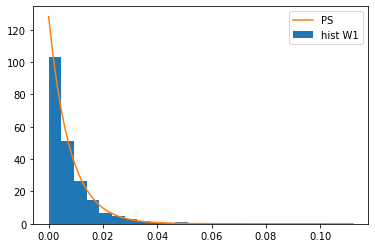

In [18]:
fig,ax = plt.subplots()
ax.hist(W1, bins=np.arange(0.0,1.01*W1[-1],bin_width), density=True)
X = [ 1.01*(W1[-1]) * 0.001 * (i+0.5) for i in range(1000) ]
ax.plot(X,[ p(x,labda) for x in X ])

ax.legend(['PS', 'hist W1'])
plt.show()

In [19]:
ctr_lst2 = [0 for _ in range(b) ]
for x in W2:
    n = int(x//bin_width)
    if(n<b):
        ctr_lst2[n] += 1/len(W2)
print([round(x,3) for x in ctr_lst2])
lenW2 = len(W2)
print(lenW2)

[0.09, 0.684, 0.186, 0.029, 0.009, 0.0, 0.0, 0, 0.001, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2560


# Noisy QV circuits

In the case of pure noise, every outcome is equally likely and we expect a peak in the histogram at this point. Statistical fluctuations will make this a normal distribution with a mean of $2^{-q}$. The standard deviation is given by $2/N$.

This can be used to fit the error parameter from a series of noisy QV experiments. In the distribution of the probabilities a normal distribution will appear in the exponential distribution. Fitting this as good as possible may tell the success rate for a error-free execution.

Theoretically, we expect that a QV experiment will fail, if the probability of an error-fre run sinks below $a=0.48$.

In [20]:
labda = 2**q

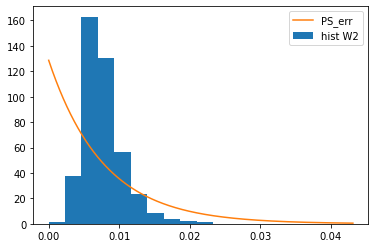

In [21]:
fig,ax = plt.subplots()
ax.hist(W2, bins=np.arange(0.0,W2[-1],bin_width/2), density=True)
X = [ 1.01*(W2[-1]) * 0.001 * (i+0.5) for i in range(1000) ]
ax.plot(X,[ p(x,labda) for x in X ])

ax.legend(['PS_err', 'hist W2'])
plt.show()

In [22]:
%%time
def random_answers(q, nr_shots):
    keys = all_keys(q)
    counts = {}
    for key in keys:
        counts[key] = 0
    for _ in range(nr_shots):
        k = np.random.choice(keys)
        counts[k] += 1
    return counts

nr_shots = Nr_shots
W3 = [ ]
for j in range(n_tests):
    counts3 = random_answers(q, nr_shots)

    for key in all_keys(q):
        k = key
        l3 = 0.0
        if key in counts3.keys():
            l3 = counts3[key]/nr_shots
        insert = 0
        for i in range(len(W3)):
            if( l3 < W3[i] ):
                W3.insert(i,l3)
                insert=1
                break
        if(insert==0):
            W3.append(l3)


CPU times: user 14.9 s, sys: 61.2 ms, total: 14.9 s
Wall time: 16.2 s


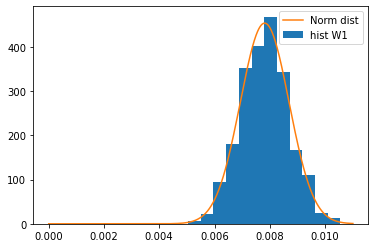

In [23]:
fig,ax = plt.subplots()
bin_width3 = 1.01*W3[-1] / b
ax.hist(W3, bins=np.arange(0.0,1.01*W3[-1],bin_width3), density=True)
X = [ 1.01*(W3[-1]) * 0.001 * (i+0.5) for i in range(1000) ]
mu = 2**(-q)
sigma = np.sqrt( mu*(1-mu)/nr_shots )
ax.plot(X,[ nd(x,mu, sigma) for x in X ])

ax.legend(['Norm dist', 'hist W1'])
#plt.savefig('purenoise.png')
plt.show()

In [24]:
print(mu, np.sqrt( mu*(1-mu)/(nr_shots) ))

0.0078125 0.000880380018785781


# Fitting

In [25]:
labda = 2**q
mu = 2**(-q)
err_par = 0.5
sigma = np.sqrt( mu*(1-mu)/(err_par * nr_shots) )

weight_p_err = p_err_scores(labda, q, np.sqrt( mu*(1-mu)/(err_par * nr_shots) ), err_par, b, bin_width)
best_diff = sum( abs( weight_p_err[i] - ctr_lst2[i] )**2 for i in range(b) )

cont = 1
while cont==1 :
    cont = 0
    err_lst = []
    for i in range(1,20):
        if(err_par + 0.01*i <= 1.0):
            err_lst.append(err_par + 0.01*i)
        if(err_par - 0.01*i >= 0.0):
            err_lst.append(err_par - 0.01*i)
    #print(err_lst)
    for ep in err_lst:
        weight_p_dummy = p_err_scores(labda, q, np.sqrt( mu*(1-mu)/(ep * nr_shots) ), ep, b, bin_width)
        abs_diff = sum( abs( weight_p_dummy[i] - ctr_lst2[i] )**2 for i in range(b) )
        if(abs_diff<best_diff):
            best_diff = abs_diff
            err_par = ep
            cont = 1


print(round(np.sqrt(best_diff),3), err_par)
weight_p_err = p_err_scores(labda, q, 2/(2*err_par*n_tests), err_par, b, bin_width)
for i in range(b):
    print(i, round(ctr_lst2[i], 2), round(weight_p_err[i], 2))

a = 1-err_par
print(a)

0.105 0.6799999999999999
0 0.09 0.16
1 0.68 0.09
2 0.19 0.06
3 0.03 0.04
4 0.01 0.03
5 0.0 0.02
6 0.0 0.02
7 0 0.02
8 0.0 0.02
9 0.0 0.02
10 0 0.01
11 0 0.01
12 0 0.01
13 0 0.01
14 0 0.01
15 0 0.01
16 0 0.01
17 0 0.01
18 0 0.01
19 0 0.01
20 0 0.01
21 0 0.01
22 0 0.01
23 0 0.01
0.32000000000000006


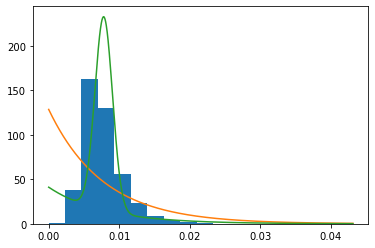

In [26]:
fig,ax = plt.subplots()
ax.hist(W2, bins=np.arange(0.0,W2[-1],bin_width/2), density=True)
X = [ 1.01*(W2[-1]) * 0.001 * (i+0.5) for i in range(1000) ]
ax.plot(X,[ p(x,labda) for x in X ])

ax.plot(X,[ a * p(x,labda) + (1-a) * nd(x, 2**(-q), sigma) for x in X ])

plt.show()

In [27]:
avg_gate_depth = 21.521
avg_gate_size = 38.973

power = (avg_gate_depth/100)
c = (a/(0.99**q))**(1/power)
print(c, power, q, avg_gate_depth)

0.006959678436147799 0.21521 7 21.521


In [28]:
powers = (avg_gate_size/100)
cs = (a/(0.99**q))**(1/powers)
print(cs, powers, q, avg_gate_size)

0.0643682476122396 0.38972999999999997 7 38.973
